### A nice Python function to help read data

We still need our helper function read_traffic

In [1]:
import subprocess
import datetime
import pandas as pd

def read_traffic(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else []
    if display_filter:
        display_filters.append(display_filter)
    filterspec = "-Y '%s'" % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    #print cmd
    proc = subprocess.Popen(cmd, shell = True, 
                                 stdout=subprocess.PIPE)
    if timeseries:
        df = pd.read_table(proc.stdout, 
                        index_col = "frame.time_epoch", 
                        parse_dates=True, 
                        date_parser=datetime.datetime.fromtimestamp)
    else:
        df = pd.read_table(proc.stdout)
    return df

## Analyze the file 1n1_ovs1.pcap

In [2]:
fields=["tcp.stream", "tcp.time_delta"]
ts=read_traffic("traffic_with_cookies.pcap", fields, timeseries=True, strict=True)
ts1 = read_traffic("traffic_no_cookies.pcap", fields, timeseries=True, strict=True)

In [3]:
import numpy as np
ts['capture.time']=ts.index.to_datetime()
ts1['capture.time']=ts1.index.to_datetime()
ts1.head()

,tcp.stream,tcp.time_delta,capture.time
frame.time_epoch,,,
2017-03-30 14:21:55.978090,0,0.000000,2017-03-30 14:21:55.978090
2017-03-30 14:21:55.978306,0,0.000216,2017-03-30 14:21:55.978306
2017-03-30 14:21:55.978328,0,0.000022,2017-03-30 14:21:55.978328
2017-03-30 14:21:55.978624,0,0.000296,2017-03-30 14:21:55.978624
2017-03-30 14:21:55.978752,0,0.000128,2017-03-30 14:21:55.978752


Now, we can group packets into streams.

In [4]:
grouped=ts.groupby("tcp.stream")
grouped1=ts1.groupby("tcp.stream")
#grouped["capture.time"] = pd.to_datetime(grouped["capture.time"])

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

streams=grouped.agg({'capture.time':[np.min, np.max]})
streams["duration"] = streams["capture.time"]["amax"].sub(streams["capture.time"]["amin"])
#streams["duration"] = streams["capture.time"]["amax"].diff()
streams["duration"] = streams["duration"].apply(lambda x: x.total_seconds())
streams["start_time"] = streams["capture.time"]["amin"]
#streams = streams.drop("capture.time", axis=1)
streams.to_csv("with_cookies.csv")

streams.head()

capture.time                             duration  \
                                 amin                       amax             
tcp.stream                                                                   
0          2017-03-30 14:25:46.766608 2017-03-30 14:25:46.773253  0.006645   
1          2017-03-30 14:25:47.781135 2017-03-30 14:25:47.786310  0.005175   
2          2017-03-30 14:25:48.794170 2017-03-30 14:25:48.799466  0.005296   
3          2017-03-30 14:25:49.807156 2017-03-30 14:25:49.813471  0.006315   
4          2017-03-30 14:25:50.821379 2017-03-30 14:25:50.826528  0.005149   

                           start_time  
                                       
tcp.stream                             
0          2017-03-30 14:25:46.766608  
1          2017-03-30 14:25:47.781135  
2          2017-03-30 14:25:48.794170  
3          2017-03-30 14:25:49.807156  
4          2017-03-30 14:25:50.821379

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


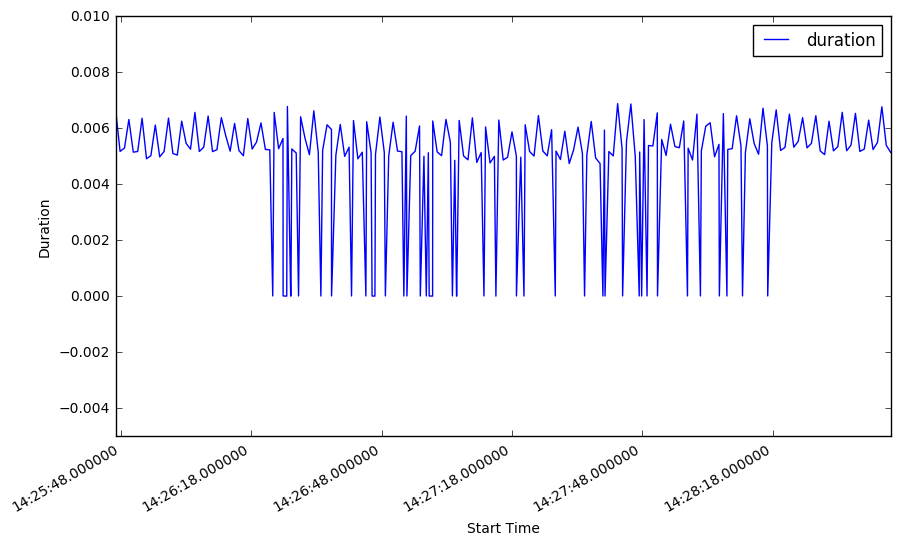

In [6]:
import matplotlib.pyplot as plt

ax = streams.plot(x='start_time',y='duration', figsize=(10, 6), ylim=(-0.005,0.01))
ax.set_xlabel("Start Time")
ax.set_ylabel("Duration")
plt.show()

Change the column names and the index name

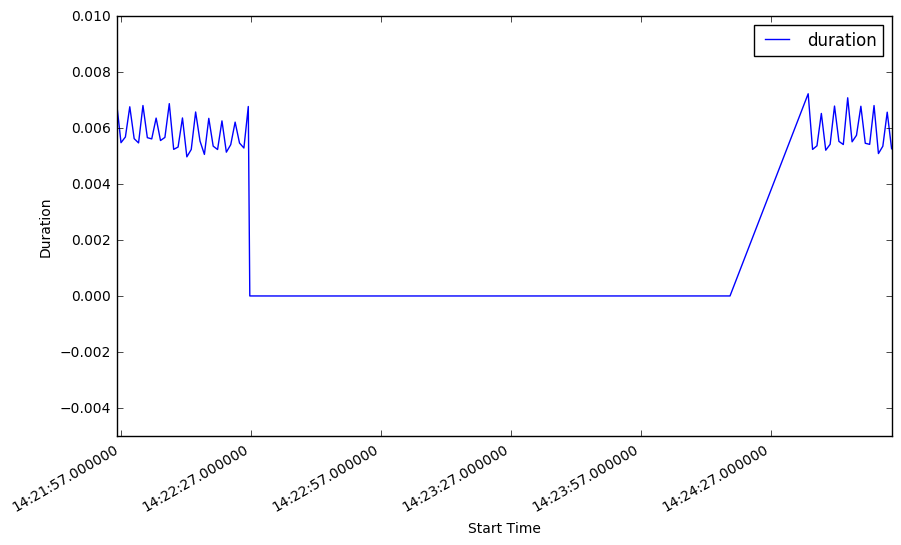

In [7]:
epoch = datetime.datetime.utcfromtimestamp(0)

streams1=grouped1.agg({'capture.time':[np.min, np.max]})
streams1["duration"] = streams1["capture.time"]["amax"].sub(streams1["capture.time"]["amin"])
#streams1["duration"] = streams1["capture.time"]["amax"].diff()
streams1["duration"] = streams1["duration"].apply(lambda x: x.total_seconds())
streams1["start_time"] = streams1["capture.time"]["amin"]
#streams = streams.drop("capture.time", axis=1)
streams1.to_csv("without_cookies.csv")

ax1 = streams1.plot(x='start_time',y='duration', figsize=(10, 6), ylim=(-0.005,0.01))
ax1.set_xlabel("Start Time")
ax1.set_ylabel("Duration")
plt.show()